In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
import numpy as np
import scipy.integrate as integ
from astropy.io import ascii
from scipy import interpolate
import scipy.stats as stats
from astropy.table import Table, Column
import readsnap as rs
reload(rs)


plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.borderpad'] = 0.1
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.handletextpad'] = 0.1
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 15


# Constants in CGS

G = 6.6726e-08
Ro = 6.96e10
Mo = 1.99e33
c = 2.9979e+10
day = 60*60*24

DistUnit = Ro
MassUnit = Mo
TimeUnit = np.sqrt(DistUnit**3/(G*MassUnit))
VelUnit = DistUnit/TimeUnit
AngMomUnit = DistUnit*VelUnit*MassUnit

SpinUnit = AngMomUnit*c/(G*Mo**2)



Tday = TimeUnit/(60*60*24)

#=====================================================
# Finds index of the element in an array 
# with the closest value to "value"

def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
#     return array[idx]
        return idx






## data from snapshots and dynamics file

In [3]:
def snapdata(path,snap):
    data = rs.readsnap(path,snap,0)
    dataBH = rs.readsnap(path,snap,5,skip_bh = 1)
    dataSTAR = rs.readsnap(path,snap,4)
    
    return data,dataBH,dataSTAR

def Get_dynamics(filename):

    """Getting the data from the dynmaics file"""
    
    dyn = np.genfromtxt(filename)    
    
    colnames = ('t','Macc_bh','Engy_bh','PaccX_bh','PaccY_bh','PaccZ_bh','LaccX_bh','LaccY_bh' \
                ,'LaccZ_bh','M_gas','X_gas','Y_gas','Z_gas','PX_gas','PY_gas','PZ_gas' \
                ,'LX_gas','LY_gas','LZ_gas', 'M_star','X_star','Y_star','Z_star','PX_star' \
                ,'PY_star','PZ_star','LX_star','LY_star','LZ_star','M_bh','X_bh','Y_bh' \
                ,'Z_bh','PX_bh','PY_bh','PZ_bh','LX_bh','LY_bh','LZ_bh','Macc_star', 'Engy_star' \
                ,'PaccX_star','PaccY_star','PaccZ_star','LaccX_star','LaccY_star' \
                ,'LaccZ_star','LaccX_starCM','LaccY_starCM','LaccZ_starCM','LaccX_bhCM' \
                ,'LaccY_bhCM','LaccZ_bhCM','rp')
    
    print np.shape(dyn), len(colnames)
    dat = Table(dyn,names=colnames)
    

    return dat



## radial velocity in explosion

In [3]:
def vrad(data,dataBH):
    
    # get position and velocity from bh frame
    posgasX = data['p'][:,0] - dataBH['p'][0,0] 
    posgasY = data['p'][:,1] - dataBH['p'][0,1] 
    posgasZ = data['p'][:,2] - dataBH['p'][0,2] 

    velgasX = data['v'][:,0] - dataBH['v'][0,0] 
    velgasY = data['v'][:,1] - dataBH['v'][0,1] 
    velgasZ = data['v'][:,2] - dataBH['v'][0,2] 

    # radius and radial velocity
    R = np.sqrt(posgasX**2 + posgasY**2 + posgasZ**2)
    Vrad  = (velgasX*posgasX + velgasY*posgasY + velgasZ*posgasZ)/R
    
    # Angular momentum of each particle
    A = (posgasX*velgasY - posgasY*velgasX)*data['m']
    
    # bin for plotting
    nbin = 400
    Vradb, Rb, bin_id = stats.binned_statistic(R,Vrad,bins=nbin,statistic='mean')
    Rave = (Rb[:-1] + Rb[1:])*0.5
    
    Mbin, Rb, bin_id = stats.binned_statistic(R,data['m'],statistic='sum',bins=nbin)
    Rave = (Rb[:-1] + Rb[1:])*0.5
    
    Abin, Rb, bin_id = stats.binned_statistic(R,A,statistic='sum',bins=nbin)
    
    #getting bh data
    Mbh0 = dataBH['m']

    return R,Vrad,A,Rave,Vradb,(np.cumsum(Mbin)+Mbh0),Abin


def escvel(data,dataBH):
    
    R,Vrad,A,Rave,Vradb,Mbin,Abin = vrad(data,dataBH)
    
    vesc = np.sqrt(2*G*Mbin*Mo/(Rave*Ro))

    return R,Vrad,A,Rave,Vradb,Mbin,vesc,Abin
    
    

## Estimating the amount of torqued material



The bound material will reach a radius $r_{max}$:

\begin{equation}
\frac{1}{2} m v_i^2 - \frac{GM(r)m}{r_i} = - \frac{GM(r)m}{r_{max}}
\end{equation}

\begin{equation}
\rightarrow r_{max} = \frac{- GM(r)m}{\frac{1}{2} m v_i^2 - \frac{GM(r)m}{r_i}} = \frac{- GM(r)}{\frac{1}{2} v_i^2 - \frac{GM(r)}{r_i}}
\end{equation}

Deviding by $v_{esc}^2=\frac{2GM(r)}{r_i}$:
\begin{equation}
r_{max} = \frac{- \frac{1}{2}r_i} {\frac{1}{2}\left(\frac{v_i}{v_{esc}}\right)^2 - \frac{1}{2} } = \frac{r_i} {1 -\left(\frac{v_i}{v_{esc}}\right)^2 }
\end{equation}

gives an nice version of $r_{max}$.\\

Because the velocity profiles are very step, the fast ejecta will leave the binary quickly, and material below escape velocity will fall back pretty quickly. The small amount of material that will be torqued significantly, is the material reaching the orbital separation, before collapsing back onto the black hole. \\

The amount of material directly accreted depends on how strong the explosion is 






In [4]:
# function for looping through all R values needed
def masscal(path,snap,Rlist):                         # path is the directory of the snapshots
                                                      # snap is one number from a list with the number of snapshots
                                                      # Rlist is a list of interesting R values for mass position
                                                      
    #get data from snapshot
    data,dataBH,dataSTAR = snapdata(path,snap)
    
    #get BINNED radius, velocity, masscoordinate and escape velocity 
    R,Vrad,A,Rave,Vradbin,M,vesc,Abin = escvel(data,dataBH)
    
    # bound material has velocity below escape velocity
    mfunc    = interpolate.interp1d(Rave, M,bounds_error=None,fill_value='extrapolate')
    vesc     = np.sqrt(2*G*mfunc(R)*Mo/(R*Ro))
    
    bound    = Vrad*VelUnit<vesc
    
    # create arrays for bound material (not binned quantities)
    Rb    = np.array(R[bound])
    Vradb = np.array(Vrad[bound])
    vescb = np.array(vesc[bound])
    Ab    = np.array(A[bound])
    
    
    # maximum radius reached
    rmax = Rb / (1.0 - (Vradb*VelUnit/vescb)**2)
    
    # lost mass with velocity above escape
    Mlost = sum(data['m'][-bound])
    
    # bound particles with velocity below escape
    Mbound = data['m'][bound]
    
    # find amount of already acrreted angular momentum from dyn file
    dyn = Get_dynamics(path+'dynamics.txt')
    idx = find_nearest(dyn['M_bh'],dataBH['m'])
    Lacc = dyn['LaccZ_bh'][idx]
    print 'is ths the right type ',type(Lacc),type(dataBH['m'][0])
    
    # mass passing list of important radii
    Mdisk   = np.zeros(len(Rlist))
    Mdirect = np.zeros(len(Rlist))

    # Ang mom passing list of important radii
    Angdisk   = np.zeros(len(Rlist))
    Angdirect = np.zeros(len(Rlist))
    

    for i in range(len(Rlist)):
        
        Mdirect[i] = sum(Mbound[rmax<Rlist[i]])+dataBH['m'][0]
        Mdisk[i]   = sum(Mbound[rmax>Rlist[i]])  
        
        Angdirect[i] = sum(Ab[rmax>Rlist[i]])+Lacc
        Angdisk[i]   = sum(Ab[rmax<Rlist[i]])
    
    return Mlost,Mdisk,Mdirect,Angdisk,Angdirect






## Estimating the spin

for $z_1$ and $M_1$ are the initial values
\begin{equation}
\frac{z}{z_1} = \left(\frac{M_1}{M}\right)^2
\end{equation}

From this equation get the new $z$ given the amount of final mass, value and calculate a 
\begin{equation}
a(z) = \frac{1}{3} z^{1/2} \left[ 4- (3z - 2)^{1/2} \right]
\end{equation}


In [5]:
# spin already accreted
def spin(dyn):
    Lacc = (np.sqrt(dyn['LaccZ_bh']**2))*AngMomUnit
    bh_spin = Lacc*c/(G*(dyn['M_bh']*Mo)**2)
    return bh_spin

def geta_direct(Angdirect,Mdirect):
    
    # get spin from total angular momentum accreted directly
    Lacc = np.sqrt(Angdirect**2)*AngMomUnit 
    spindirect = Lacc*c/(G*((Mdirect)*Mo)**2)
    
    return spindirect

def get_r_isco(a):
    
    
    print 'what type is a ',type(a),'and its shape',np.shape(a)
    w1 = 1. + (1. - a**2.)**(1./3.) * ((1. + a)**(1./3.) + (1 - a)**(1./3.))
    w2 = (3.*a**2 + w1**2.)**(1./2.)
    
    # z = r_isco/M
    z = 3 + w2 - ((3 - w1)*(3 + w1 + 2*w2))**(1./2.)
    return z


def disk(Mdirect,Mlist,Angdirect):
    
    # get spin from directly falling material
    a_direct = geta_direct(Angdirect,Mdirect)
    
    
    # get new r_ISCO
    z_1 = get_r_isco(a_direct)
    Mfinal = Mdirect + Mlist
    z = (Mdirect/Mfinal)**2 * z_1
    
    
    afinal = 1./3. * z**(1./2.) * (4 - np.sqrt(3.*z - 2) )
    
    return afinal



## Comparing 13, 28 and 34 star

In [25]:
filename ='/Users/sophielundschroder/Desktop/snapshots/Alowres_10/run2/dynamics.txt'
Adyn10 = Get_dynamics(filename)

filename ='/Users/sophielundschroder/Desktop/snapshots/Alowres_40/run2/dynamics.txt'
Adyn40 = Get_dynamics(filename)

filename ='/Users/sophielundschroder/Desktop/snapshots/Alowres_70/run2/dynamics.txt'
Adyn70 = Get_dynamics(filename)



filename ='/Users/sophielundschroder/Desktop/snapshots/Dlowres_10/run2/dynamics.txt'
Ddyn10 = Get_dynamics(filename)

filename ='/Users/sophielundschroder/Desktop/snapshots/Dlowres_40/run2/dynamics.txt'
Ddyn40 = Get_dynamics(filename)

filename ='/Users/sophielundschroder/Desktop/snapshots/Dlowres_70/run2/dynamics.txt'
Ddyn70 = Get_dynamics(filename)


# run for each explosion energy
snap = 8
# list of separations
Rlist = np.logspace(-1,1,10) # in code units

Apath10 = '/Users/sophielundschroder/Desktop/snapshots/Alowres_10/run2/'
Apath40 = '/Users/sophielundschroder/Desktop/snapshots/Alowres_40/run2/'
Apath70 = '/Users/sophielundschroder/Desktop/snapshots/Alowres_70/run2/'

AMlost10,AMlist10,AMdirect10,AAnglist10,AAngdirect10 = masscal(Apath10,snap,Rlist)
AMlost40,AMlist40,AMdirect40,AAnglist40,AAngdirect40 = masscal(Apath40,snap,Rlist)
AMlost70,AMlist70,AMdirect70,AAnglist70,AAngdirect70 = masscal(Apath70,snap,Rlist)

Adata10,AdataBH10,AdataSTAR10 = snapdata(Apath10,snap)
Adata40,AdataBH40,AdataSTAR40 = snapdata(Apath40,snap)
Adata70,AdataBH70,AdataSTAR70 = snapdata(Apath70,snap)

# run for each explosion energy
snap = 8
Cpath10 = '/Users/sophielundschroder/Desktop/snapshots/Clowres_10/'
Cpath40 = '/Users/sophielundschroder/Desktop/snapshots/Clowres_40/'
Cpath70 = '/Users/sophielundschroder/Desktop/snapshots/Clowres_70/'

CMlost10,CMlist10,CMdirect10,CAnglist10,CAngdirect10 = masscal(Cpath10,snap,Rlist)
CMlost40,CMlist40,CMdirect40,CAnglist40,CAngdirect40 = masscal(Cpath40,snap,Rlist)
CMlost70,CMlist70,CMdirect70,CAnglist70,CAngdirect70 = masscal(Cpath70,snap,Rlist)

Cdata10,CdataBH10,CdataSTAR10 = snapdata(Cpath10,snap)
Cdata40,CdataBH40,CdataSTAR40 = snapdata(Cpath40,snap)
Cdata70,CdataBH70,CdataSTAR70 = snapdata(Cpath70,snap)

# run for each explosion energy
snap = 8
Dpath10 = '/Users/sophielundschroder/Desktop/snapshots/Dlowres_10/run2/'
Dpath40 = '/Users/sophielundschroder/Desktop/snapshots/Dlowres_40/run2/'
Dpath70 = '/Users/sophielundschroder/Desktop/snapshots/Dlowres_70/run2/'

DMlost10,DMlist10,DMdirect10,DAnglist10,DAngdirect10 = masscal(Dpath10,snap,Rlist)
DMlost40,DMlist40,DMdirect40,DAnglist40,DAngdirect40 = masscal(Dpath40,snap,Rlist)
DMlost70,DMlist70,DMdirect70,DAnglist70,DAngdirect70 = masscal(Dpath70,snap,Rlist)

Ddata10,DdataBH10,DdataSTAR10 = snapdata(Dpath10,snap)
Ddata40,DdataBH40,DdataSTAR40 = snapdata(Dpath40,snap)
Ddata70,DdataBH70,DdataSTAR70 = snapdata(Dpath70,snap)






#calculate for different explosion energies
R,Vrad,A,ARave10,AVradbin10,AMbin10,Avesc10,AAbin10 = escvel(Adata10,AdataBH10)
R,Vrad,A,CRave10,CVradbin10,CMbin10,Cvesc10,CAbin10 = escvel(Cdata10,CdataBH10)
R,Vrad,A,DRave10,DVradbin10,DMbin10,Dvesc10,DAbin10 = escvel(Ddata10,DdataBH10)
R,Vrad,A,ARave40,AVradbin40,AMbin40,Avesc40,AAbin40 = escvel(Adata40,AdataBH40)
R,Vrad,A,CRave40,CVradbin40,CMbin40,Cvesc40,CAbin40 = escvel(Cdata40,CdataBH40)
R,Vrad,A,DRave40,DVradbin40,DMbin40,Dvesc40,DAbin40 = escvel(Ddata40,DdataBH40)
R,Vrad,A,ARave70,AVradbin70,AMbin70,Avesc70,AAbin70 = escvel(Adata70,AdataBH70)
R,Vrad,A,CRave70,CVradbin70,CMbin70,Cvesc70,CAbin70 = escvel(Cdata70,CdataBH70)
R,Vrad,A,DRave70,DVradbin70,DMbin70,Dvesc70,DAbin70 = escvel(Ddata70,DdataBH70)



Cspinlist10 = disk(CMdirect10,CMlist10,CAngdirect10)
Cspinlist40 = disk(CMdirect40,CMlist40,CAngdirect40)
Cspinlist70 = disk(CMdirect70,CMlist70,CAngdirect70)

Aspinlist10 = disk(AMdirect10,AMlist10,AAngdirect10)
Aspinlist40 = disk(AMdirect40,AMlist40,AAngdirect40)
Aspinlist70 = disk(AMdirect70,AMlist70,AAngdirect70)

Dspinlist10 = disk(DMdirect10,DMlist10,DAngdirect10)
Dspinlist40 = disk(DMdirect40,DMlist40,DAngdirect40)
Dspinlist70 = disk(DMdirect70,DMlist70,DAngdirect70)




(333, 54) 54
(241, 54) 54
(249, 54) 54
(174, 54) 54
(128, 54) 54
(125, 54) 54
('npart_file: ', array([54330,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([54330,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', array([54330,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([54330,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', array([54330,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([54330,     0,     0,     0,     0,     1], dtype=uint32))
(333, 54) 54
is ths the right type  <type 'numpy.float64'> <type 'numpy.float64'>


/Users/sophielundschroder/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


('npart_file: ', array([79167,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([79167,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', array([79167,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([79167,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', array([79167,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([79167,     0,     0,     0,     0,     1], dtype=uint32))
(241, 54) 54
is ths the right type  <type 'numpy.float64'> <type 'numpy.float64'>
('npart_file: ', array([81514,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([81514,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', array([81514,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([81514,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', array([81514,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array

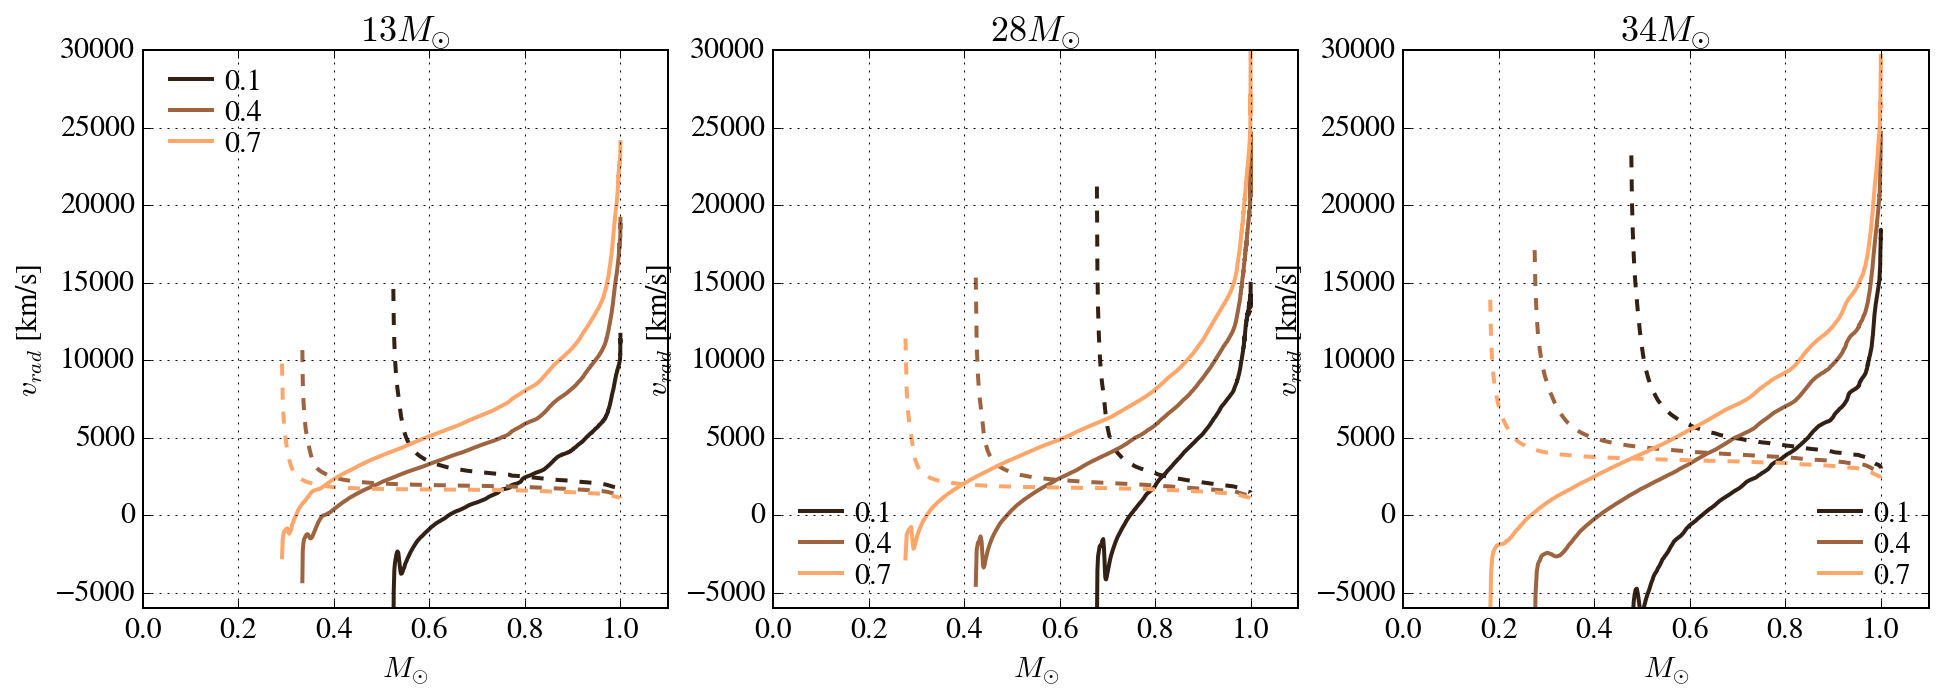

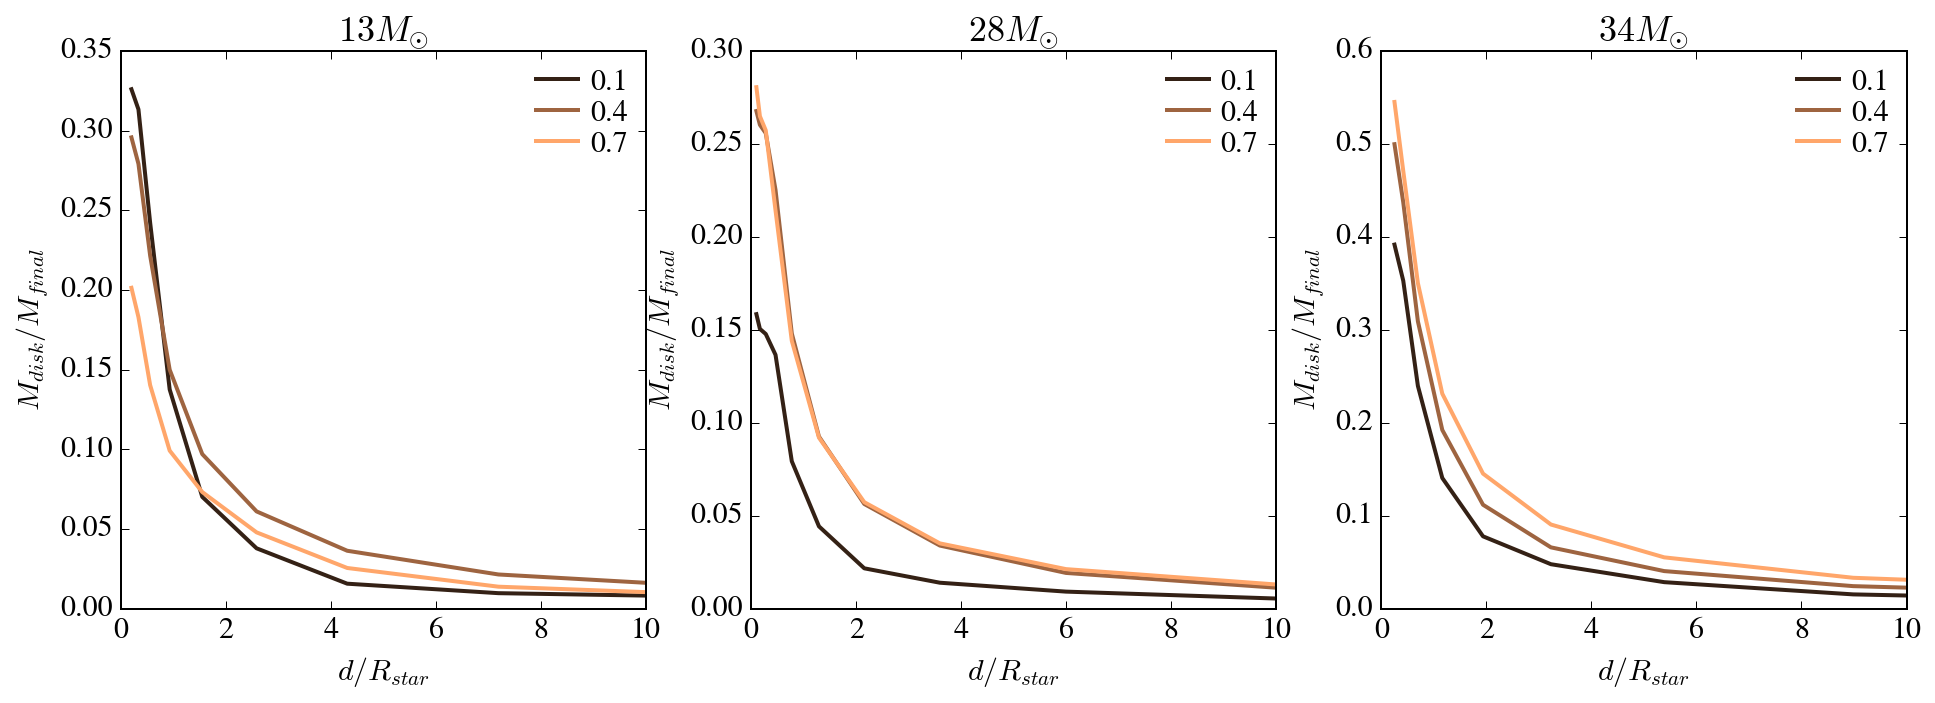

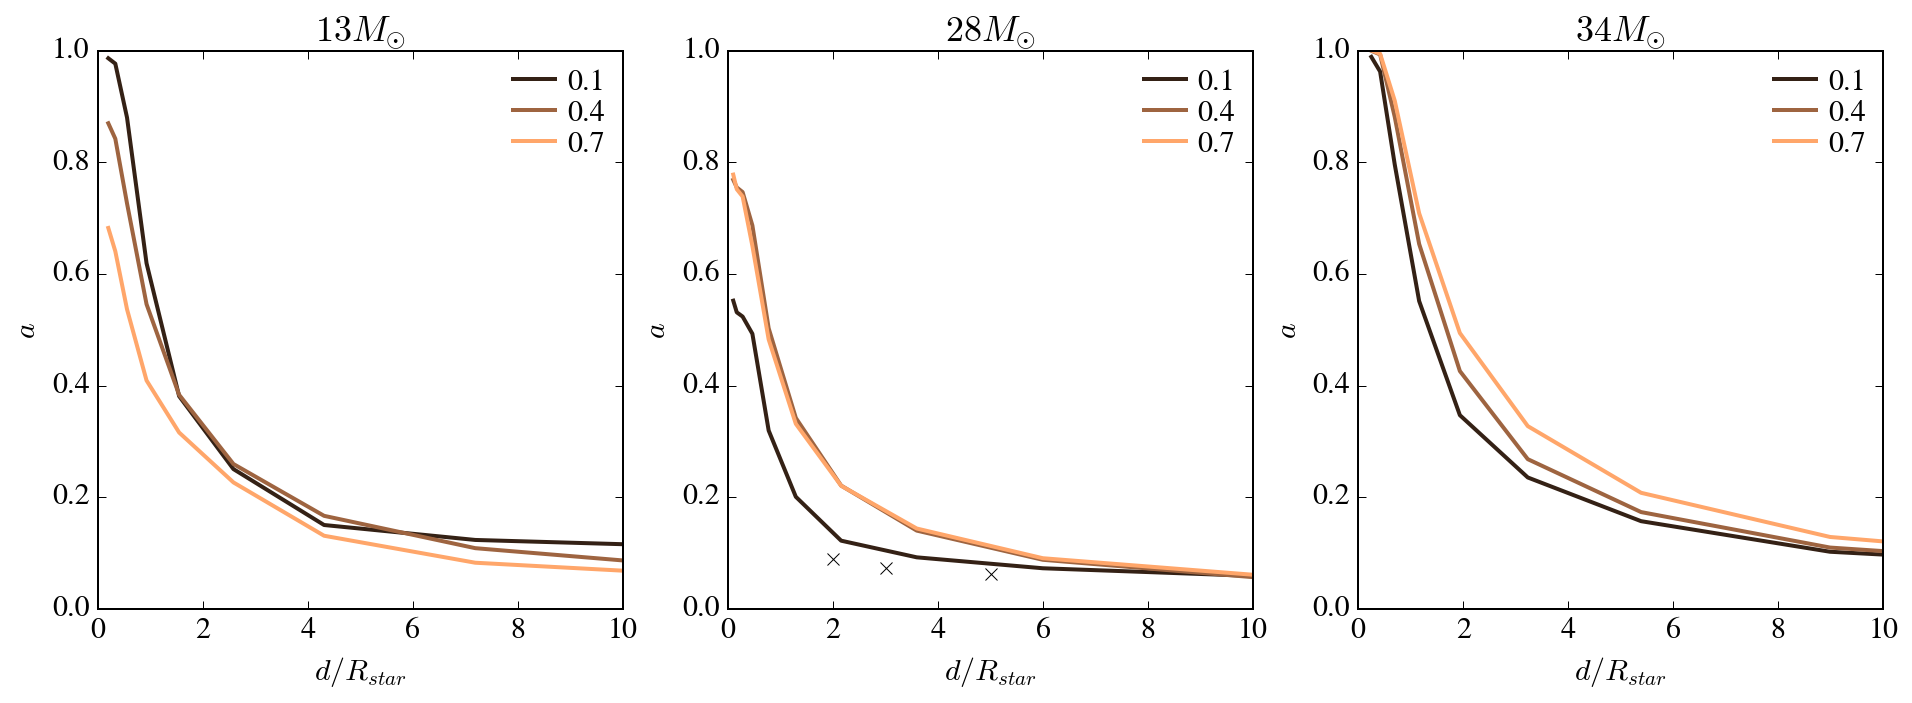

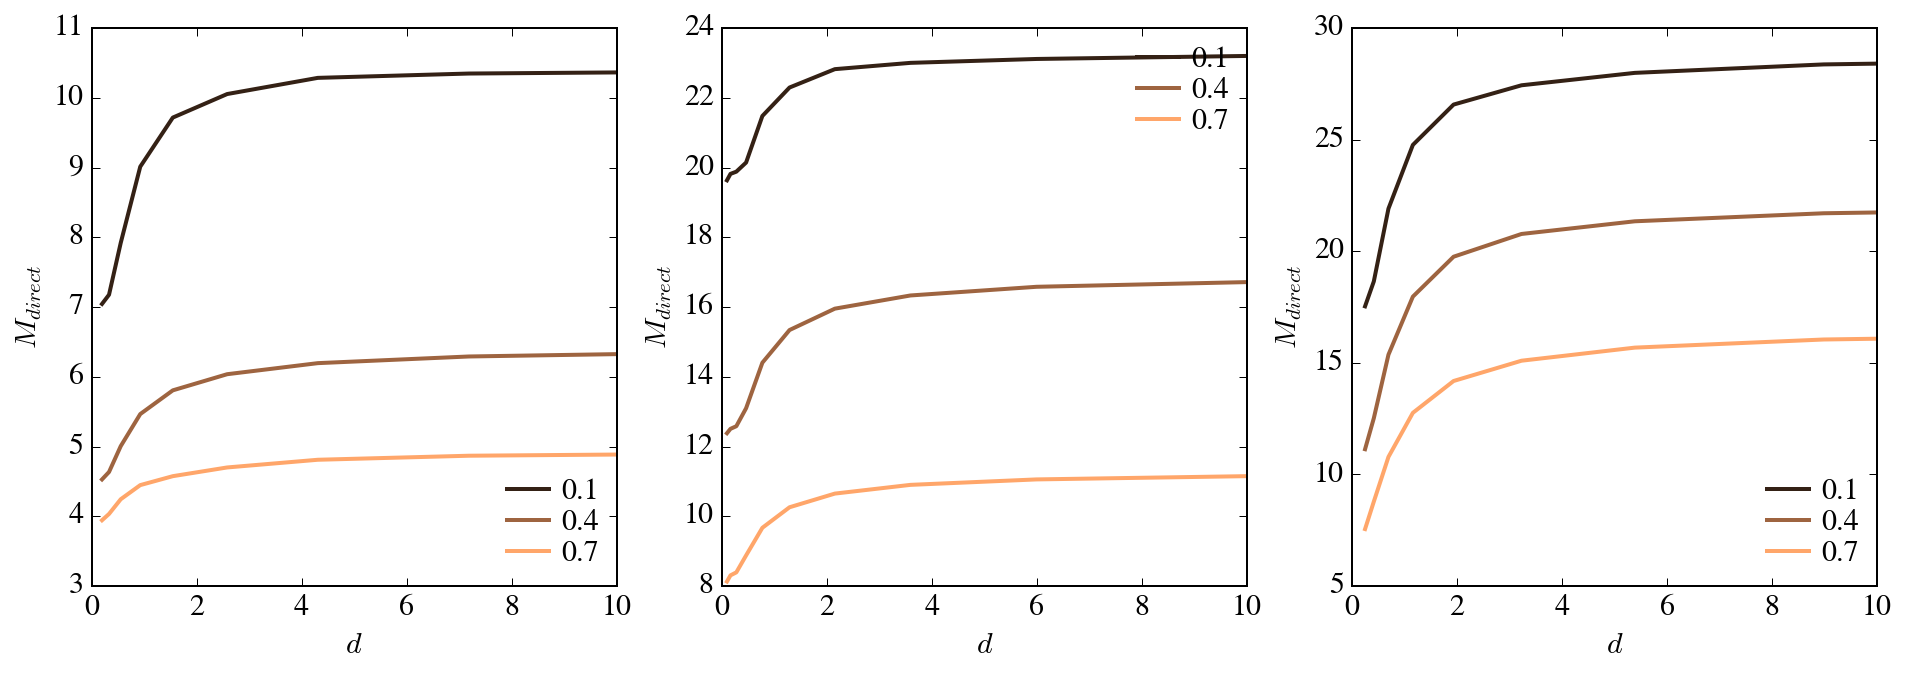

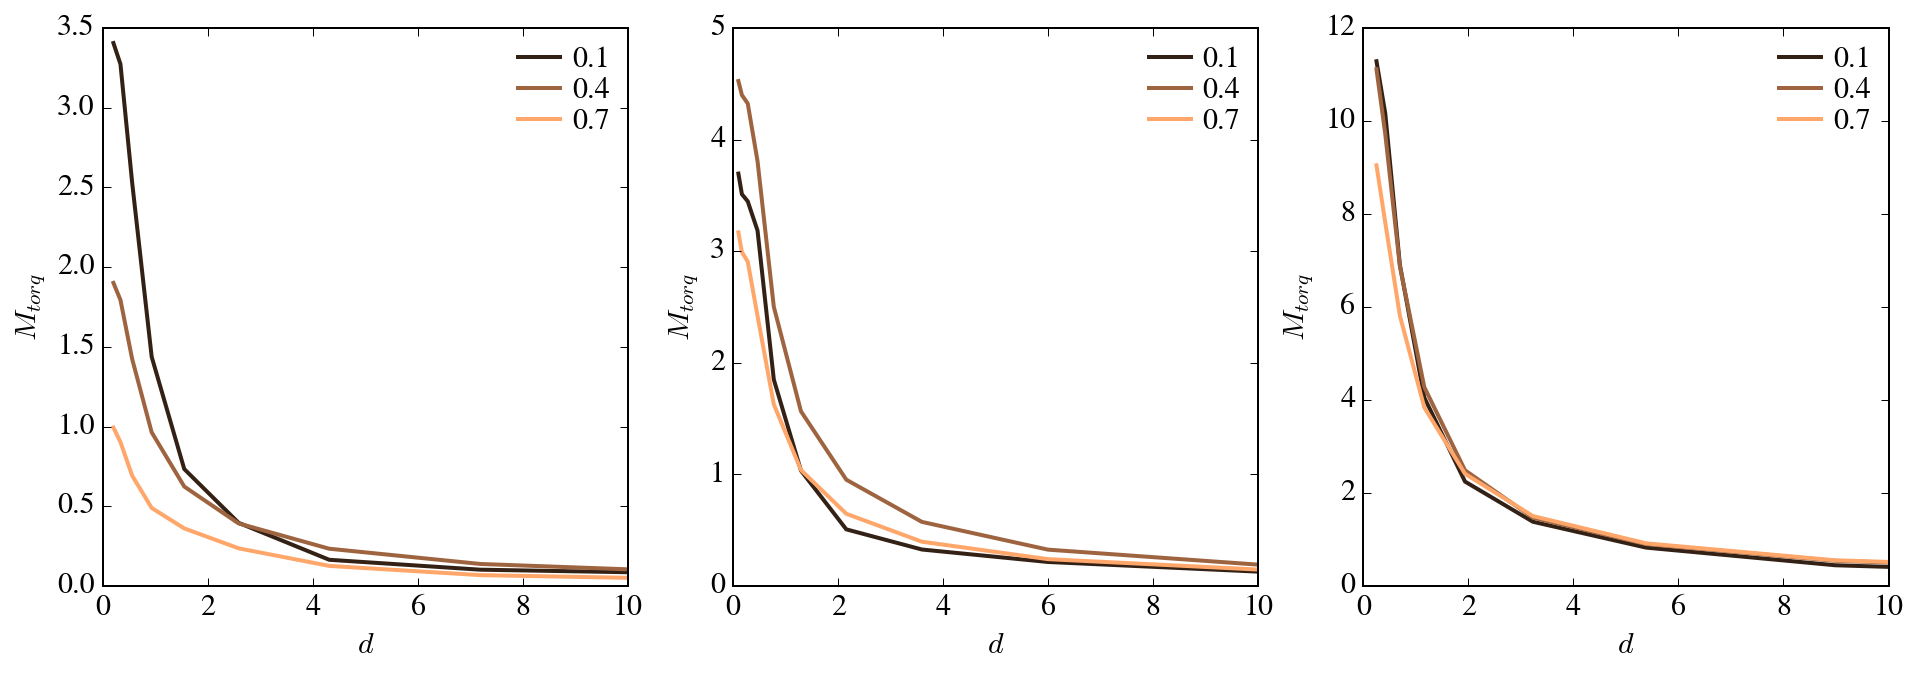

In [26]:

plt.rcParams['figure.figsize'] = (16,5)

def plotting(Mbin10,Mbin40,Mbin70,Vrad10,Vrad40,Vrad70,vesc10,vesc40,vesc70,\
             Rlist,Mlist10,Mlist40,Mlist70,Mdirect10,Mdirect40,Mdirect70,\
             spinlist10,spinlist40,spinlist70,i,Rstar,title):

    plt.figure(1)

    plt.subplot(1,3,i)
    plt.plot(Mbin10/Mbin10[-1],Vrad10*VelUnit/1e5,color=plt.cm.copper(1./6.),label='0.1')
    plt.plot(Mbin10/Mbin10[-1],vesc10/1e5,'--',color=plt.cm.copper(1./6.))


    plt.plot(Mbin40/Mbin40[-1],Vrad40*VelUnit/1e5,color=plt.cm.copper(3./6.),label='0.4')
    plt.plot(Mbin40/Mbin40[-1],vesc40/1e5,'--', color=plt.cm.copper(3./6.))


    plt.plot(Mbin70/Mbin70[-1],Vrad70*VelUnit/1e5,color=plt.cm.copper(5./6.),label='0.7')
    plt.plot(Mbin70/Mbin70[-1],vesc70/1e5,'--', color=plt.cm.copper(5./6.))
    plt.xlabel(r'$M_{\odot}$')
    plt.ylabel(r'$v_{rad}$ [km/s]')
    plt.ylim(-6000,30000)
    plt.xlim(0.0,1.1)
    plt.legend(loc='best')
    plt.grid()
    plt.title(title)


    plt.figure(2)
    plt.subplot(1,3,i)
    plt.plot(Rlist/Rstar,Mlist10/(Mdirect10+Mlist10),color=plt.cm.copper(1./6.),label='0.1')
    plt.plot(Rlist/Rstar,Mlist40/(Mdirect40+Mlist40),color=plt.cm.copper(3./6.),label='0.4')
    plt.plot(Rlist/Rstar,Mlist70/(Mdirect70+Mlist70),color=plt.cm.copper(5./6.),label='0.7')
    plt.xlim(0,10)
    plt.xlabel(r'$d/R_{star}$')
    plt.ylabel(r'$M_{disk}/M_{final}$')
    plt.legend(loc='best')
    plt.title(title)
    
    plt.figure(3)
    plt.subplot(1,3,i)
    plt.plot(Rlist/Rstar,spinlist10,color=plt.cm.copper(1./6.),label='0.1')
    plt.plot(Rlist/Rstar,spinlist40,color=plt.cm.copper(3./6.),label='0.4')
    plt.plot(Rlist/Rstar,spinlist70,color=plt.cm.copper(5./6.),label='0.7')
    plt.xlim(0,10)
    plt.ylim(0,1)
    plt.xlabel(r'$d/R_{star}$')
    plt.ylabel(r'$a$')
    plt.legend(loc='best')
    plt.title(title)
    
    
    plt.figure(4)
    plt.subplot(1,3,i)
    plt.plot(Rlist/Rstar,Mdirect10,color=plt.cm.copper(1./6.),label='0.1')
    plt.plot(Rlist/Rstar,Mdirect40,color=plt.cm.copper(3./6.),label='0.4')
    plt.plot(Rlist/Rstar,Mdirect70,color=plt.cm.copper(5./6.),label='0.7')
    plt.xlim(0,10)
    plt.xlabel(r'$d$')
    plt.ylabel(r'$M_{direct}$')
    plt.legend(loc='best')
    
    plt.figure(5)
    plt.subplot(1,3,i)
    plt.plot(Rlist/Rstar,Mlist10,color=plt.cm.copper(1./6.),label='0.1')
    plt.plot(Rlist/Rstar,Mlist40,color=plt.cm.copper(3./6.),label='0.4')
    plt.plot(Rlist/Rstar,Mlist70,color=plt.cm.copper(5./6.),label='0.7')
    plt.xlim(0,10)
    plt.xlabel(r'$d$')
    plt.ylabel(r'$M_{torq}$')
    plt.legend(loc='best')
    
ARstar = 0.5
CRstar = 1.0
DRstar = 0.4
plotting(AMbin10,AMbin40,AMbin70,AVradbin10,AVradbin40,AVradbin70,Avesc10,Avesc40,Avesc70,\
             Rlist,AMlist10,AMlist40,AMlist70,AMdirect10,AMdirect40,AMdirect70,\
             Aspinlist10,Aspinlist40,Aspinlist70,1,ARstar,r'$13 M_{\odot}$')


plotting(CMbin10,CMbin40,CMbin70,CVradbin10,CVradbin40,CVradbin70,Cvesc10,Cvesc40,Cvesc70,\
             Rlist,CMlist10,CMlist40,CMlist70,CMdirect10,CMdirect40,CMdirect70,\
             Cspinlist10,Cspinlist40,Cspinlist70,2,CRstar,r'$28 M_{\odot}$')

plotting(DMbin10,DMbin40,DMbin70,DVradbin10,DVradbin40,DVradbin70,Dvesc10,Dvesc40,Dvesc70,\
             Rlist,DMlist10,DMlist40,DMlist70,DMdirect10,DMdirect40,DMdirect70,\
             Dspinlist10,Dspinlist40,Dspinlist70,3,DRstar,r'$34 M_{\odot}$')


plt.figure(1)
plt.savefig('/Users/sophielundschroder/Dropbox/Sophie_projectSpin/Paper/figures/velprofiles.pdf')
plt.figure(2)
plt.savefig('/Users/sophielundschroder/Dropbox/Sophie_projectSpin/Paper/figures/torquedmass.pdf')
plt.figure(3)
abinary = [0.089755452958,0.0739598704657,0.0626081685962]
sepbinary = [2.0,3.0,5.0]
plt.subplot(1,3,2)
plt.plot(sepbinary,abinary,'kx')
plt.savefig('/Users/sophielundschroder/Dropbox/Sophie_projectSpin/Paper/figures/diskspin.pdf')

In [27]:
def plotting_v(Mbin10,Mbin40,Mbin70,Vradbin10,Vradbin40,Vradbin70,vesc10,vesc40,vesc70,\
                 Rlist,Mlist10,Mlist40,Mlist70,Mdirect10,Mdirect40,Mdirect70,Rstar,snap):

    # compare radial velocity and escape velocity
    plt.plot(Mbin10/Mbin10[-1],Vradbin10*VelUnit/1e5,color=plt.cm.copper(1./6.),label='0.1')
    plt.plot(Mbin10/Mbin10[-1],vesc10/1e5,'--',color=plt.cm.copper(1./6.))

    plt.plot(Mbin40/Mbin40[-1],Vradbin40*VelUnit/1e5,color=plt.cm.copper(3./6.),label='0.4')
    plt.plot(Mbin40/Mbin40[-1],vesc40/1e5,'--', color=plt.cm.copper(3./6.))

    plt.plot(Mbin70/Mbin70[-1],Vradbin70*VelUnit/1e5,color=plt.cm.copper(5./6.),label='0.7')
    plt.plot(Mbin70/Mbin70[-1],vesc70/1e5,'--', color=plt.cm.copper(5./6.))
    
    plt.xlabel(r'$M_{\odot}$')
    plt.ylabel(r'$v_{rad}$ [km/s]')
    plt.ylim(-6000,30000)
    plt.xlim(0.0,1.1)
    plt.legend(loc='best')
    plt.grid()
    plt.title('snap '+ str(snap))


def plotting_ratio(Mbin10,Mbin40,Mbin70,Vradbin10,Vradbin40,Vradbin70,vesc10,vesc40,vesc70,\
                     Rlist,Mlist10,Mlist40,Mlist70,Mdirect10,Mdirect40,Mdirect70,Rstar,snap):
    
    # plot ratio of torqued material and directly falling material
    plt.plot(Rlist/Rstar,Mlist10/Mdirect10,color=plt.cm.copper(1./6.),label='0.1')
    plt.plot(Rlist/Rstar,Mlist40/Mdirect40,color=plt.cm.copper(3./6.),label='0.4')
    plt.plot(Rlist/Rstar,Mlist70/Mdirect70,color=plt.cm.copper(5./6.),label='0.7')
    plt.ylim(0,0.6)
    plt.xlabel(r'$d/R_{star}$')
    plt.ylabel(r'$M_{torq}/M_{direct}$')
    plt.legend(loc='best')
    plt.title('snap '+ str(snap))

    
def plotting_direct(Mbin10,Mbin40,Mbin70,Vradbin10,Vradbin40,Vradbin70,vesc10,vesc40,vesc70,\
                     Rlist,Mlist10,Mlist40,Mlist70,Mdirect10,Mdirect40,Mdirect70,Rstar,snap):
    
    # directly falling material
    plt.plot(Rlist/Rstar,Mdirect10,color=plt.cm.copper(1./6.),label='0.1')
    plt.plot(Rlist/Rstar,Mdirect40,color=plt.cm.copper(3./6.),label='0.4')
    plt.plot(Rlist/Rstar,Mdirect70,color=plt.cm.copper(5./6.),label='0.7')
    plt.xlabel(r'$d/R_{star}$')
    plt.ylabel(r'$M_{direct}$')
    plt.legend(loc='best')
    plt.title('snap '+ str(snap))

    
def plotting_torq(Mbin10,Mbin40,Mbin70,Vrad1bin0,Vradbin40,Vradbin70,vesc10,vesc40,vesc70,\
                     Rlist,Mlist10,Mlist40,Mlist70,Mdirect10,Mdirect40,Mdirect70,Rstar,snap):
    
    # torqued material
    plt.plot(Rlist/Rstar,Mlist10,color=plt.cm.copper(1./6.),label='0.1')
    plt.plot(Rlist/Rstar,Mlist40,color=plt.cm.copper(3./6.),label='0.4')
    plt.plot(Rlist/Rstar,Mlist70,color=plt.cm.copper(5./6.),label='0.7')
    plt.xlabel(r'$d/R_{star}$')
    plt.ylabel(r'$M_{torq}$')
    plt.legend(loc='best')
    plt.title('snap '+ str(snap))


# Function reading in different snapshots
def torq_with_time(path10,path40,path70,snap,Rlist,Rstar):
    
    #get snapshot data
    data10,dataBH10,dataSTAR10 = snapdata(path10,snap)
    data40,dataBH40,dataSTAR40 = snapdata(path40,snap)
    data70,dataBH70,dataSTAR70 = snapdata(path70,snap)
    
    # get radius, radial velocity and angular momentum
    # anf binned radius, radial velocity, mass coordinate, escape velocity and angular momenum
    R10,Vrad10,A10,Rave10,Vradbin10,Mbin10,vesc10,Abin10 = escvel(data10,dataBH10)
    R40,Vrad40,A40,Rave40,Vradbin40,Mbin40,vesc40,Abin40 = escvel(data40,dataBH40)
    R70,Vrad70,A70,Rave70,Vradbin70,Mbin70,vesc70,Abin70 = escvel(data70,dataBH70)
    
    # Lost mass, mass in the torqued region, directly falling mass, angular momentum of 
    Mlost10,Mlist10,Mdirect10,Anglist10,Angdirect10 = masscal(path10,snap,Rlist)
    Mlost40,Mlist40,Mdirect40,Anglist40,Angdirect40 = masscal(path40,snap,Rlist)
    Mlost70,Mlist70,Mdirect70,Anglist70,Angdirect70 = masscal(path70,snap,Rlist)
    
    
    # get the soin
    
    spinlist10 = disk(Mdirect10,Mlist10,Angdirect10)
    spinlist40 = disk(Mdirect40,Mlist40,Angdirect40)
    spinlist70 = disk(Mdirect70,Mlist70,Angdirect70)



    # make the plots
    plt.figure(1)
    plotting_v(Mbin10,Mbin40,Mbin70,Vradbin10,Vradbin40,Vradbin70,vesc10,vesc40,vesc70,\
                     Rlist,Mlist10,Mlist40,Mlist70,Mdirect10,Mdirect40,Mdirect70,Rstar,snap)
        
#     plt.figure(2)
#     plt.plot(Rlist/Rstar,spinlist10,color=plt.cm.copper(1./6.),label='0.1')
#     plt.plot(Rlist/Rstar,spinlist40,color=plt.cm.copper(3./6.),label='0.4')
#     plt.plot(Rlist/Rstar,spinlist70,color=plt.cm.copper(5./6.),label='0.7')
#     plt.xlim(0,10)
#     plt.ylim(0,1)
#     plt.xlabel(r'$d/R_{star}$')
#     plt.ylabel(r'$a$')
#     plt.legend(loc='best')
    











('npart_file: ', array([64667,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([64667,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', array([64667,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([64667,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', array([64667,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([64667,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', array([68754,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([68754,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', array([68754,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([68754,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', array([68754,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([68754,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', array

/Users/sophielundschroder/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


(1080, 54) 54
is ths the right type  <type 'numpy.float64'> <type 'numpy.float64'>
('npart_file: ', array([68754,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([68754,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', array([68754,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([68754,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', array([68754,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([68754,     0,     0,     0,     0,     1], dtype=uint32))
(6862, 54) 54
is ths the right type  <type 'numpy.float64'> <type 'numpy.float64'>
('npart_file: ', array([70843,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([70843,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', array([70843,     0,     0,     0,     0,     1], dtype=int32))
('npart_total:', array([70843,     0,     0,     0,     0,     1], dtype=uint32))
('npart_file: ', ar

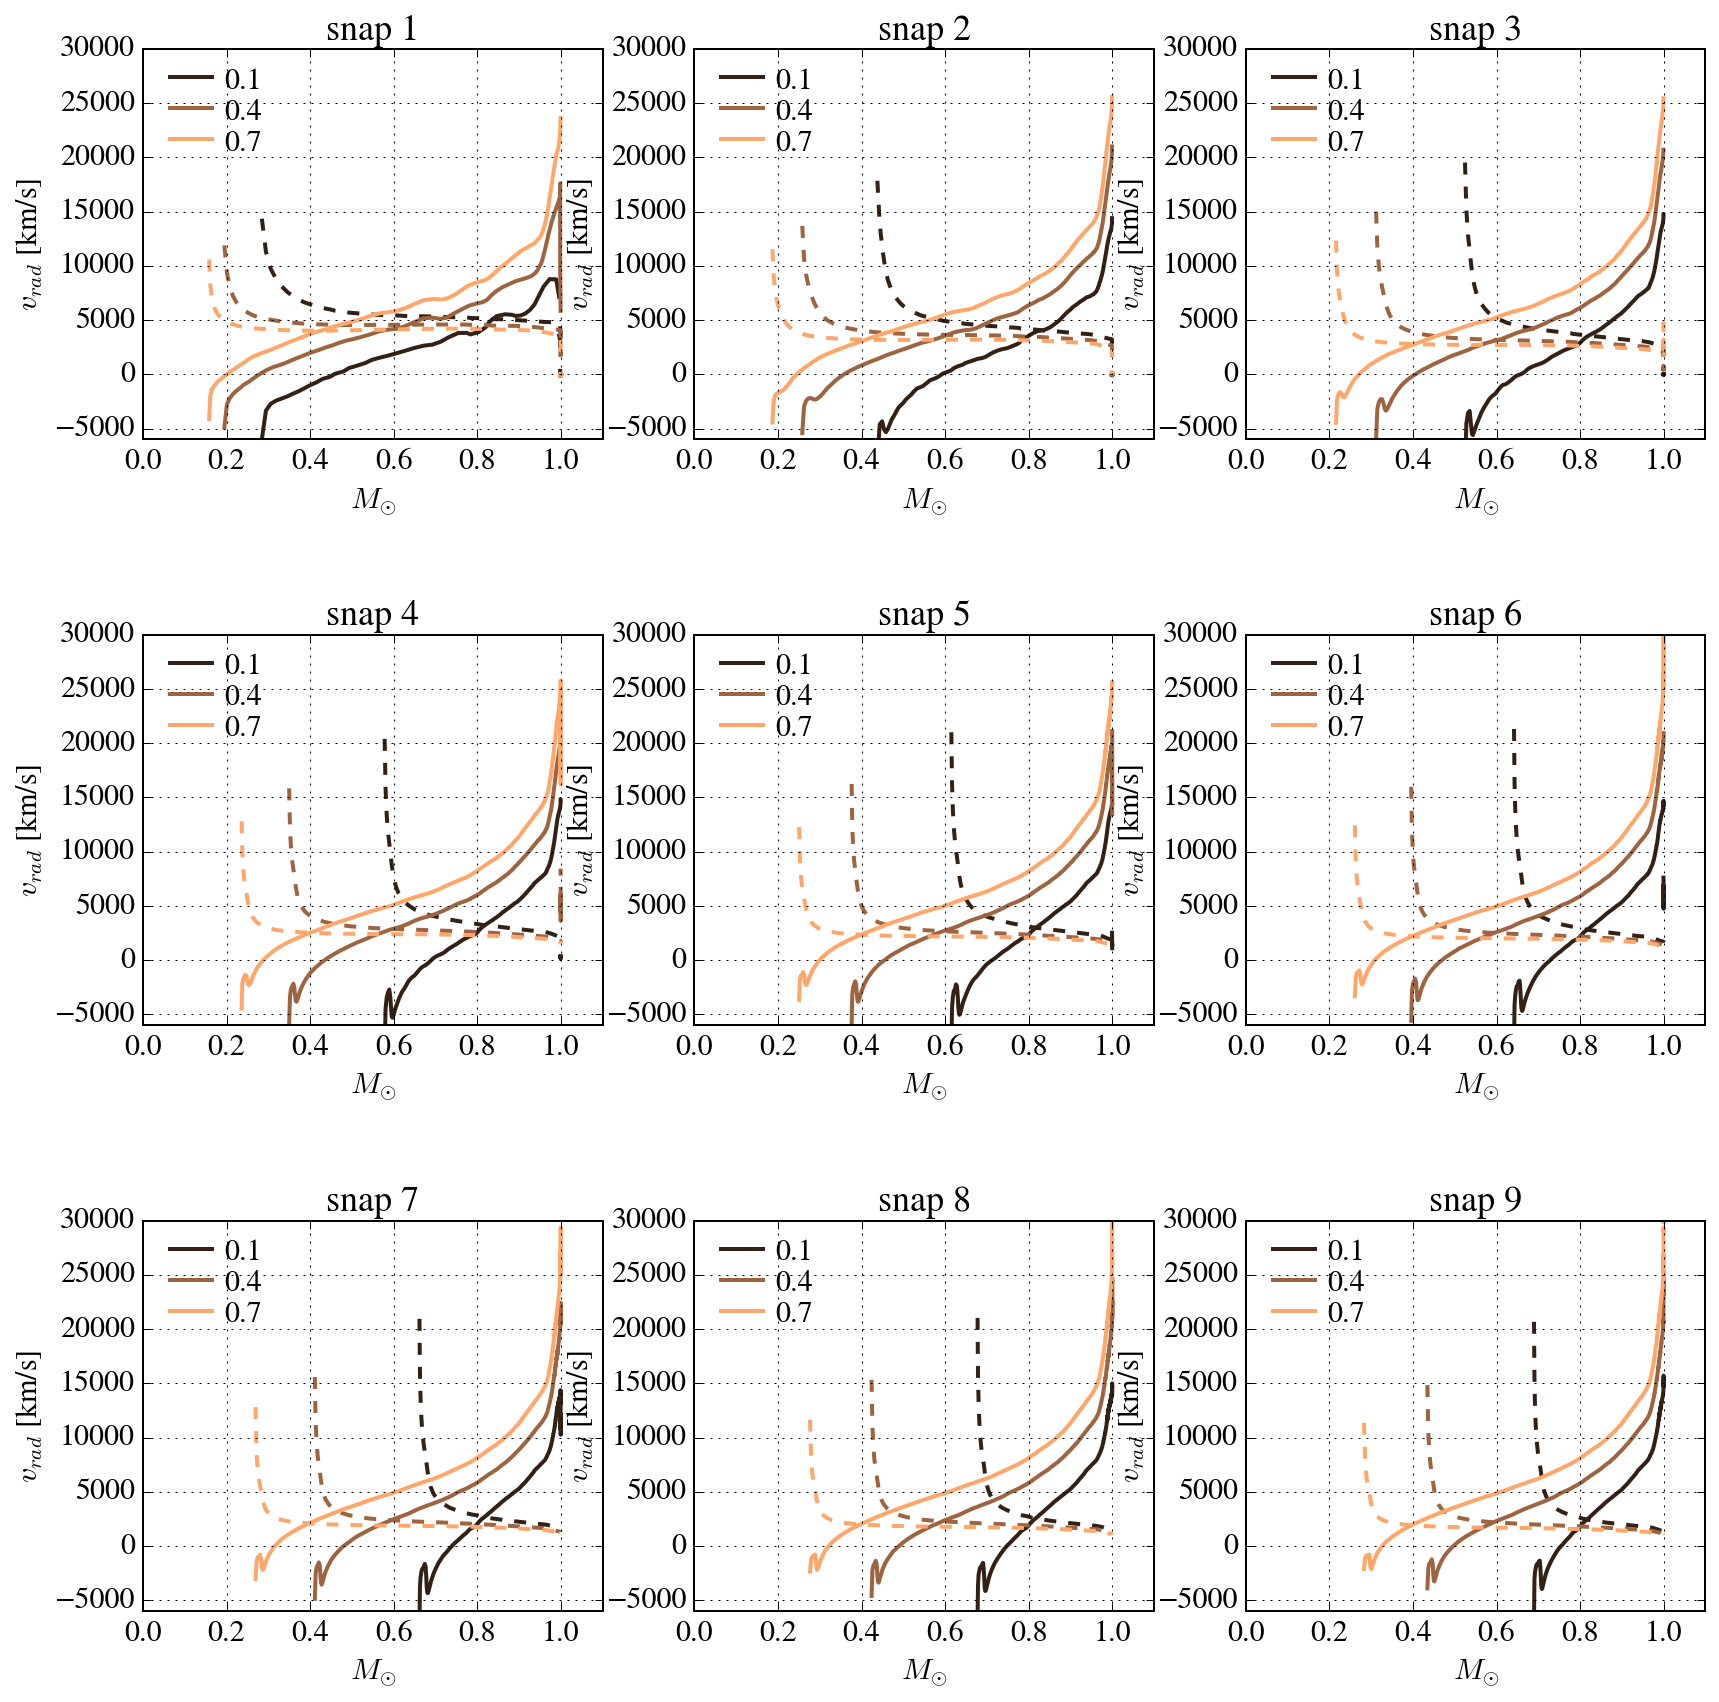

In [28]:
# Apath10 = '/Users/sophielundschroder/Desktop/snapshots/Alowres_10/run2/'
# Apath40 = '/Users/sophielundschroder/Desktop/snapshots/Alowres_40/run2/'
# Apath70 = '/Users/sophielundschroder/Desktop/snapshots/Alowres_70/run2/'

Apath10 = '/Users/sophielundschroder/Desktop/snapshots/lowres_10/run2/'
Apath40 = '/Users/sophielundschroder/Desktop/snapshots/lowres_40/run2/'
Apath70 = '/Users/sophielundschroder/Desktop/snapshots/lowres_70/run2/'



# list of separations
Rlist = np.logspace(-1,1,10) # in code units
Rstar = 1.0

# Giant plot with diffrent snapshots
plt.rcParams['figure.figsize'] = (14,14)

# loop over snapshots 1-9
for i in range(9):
    plt.subplot(3,3,i+1)
    torq_with_time(Apath10,Apath40,Apath70,i+1,Rlist,Rstar)


plt.subplots_adjust(hspace=.5)






## Calculations for the simulation

In [10]:

# from a mesa profile of a single star
data = ascii.read('/Users/sophielundschroder/Dropbox/LOGS_40/profile100.data',header_start=4)
data.colnames


['zone',
 'logT',
 'logRho',
 'logP',
 'logR',
 'luminosity',
 'logL',
 'velocity',
 'entropy',
 'conv_mixing_type',
 'csound',
 'v_div_csound',
 'total_energy',
 'v_div_r',
 'eta',
 'mu',
 'log_dr_div_cs',
 'logdq',
 'dq_ratio',
 'q',
 'radius',
 'temperature',
 'tau',
 'logtau',
 'pressure',
 'pgas_div_ptotal',
 'logPgas',
 'grada',
 'gamma1',
 'free_e',
 'abar',
 'ye',
 'opacity',
 'log_opacity',
 'eps_nuc',
 'non_nuc_neu',
 'eps_grav',
 'mlt_mixing_length',
 'log_D_mix',
 'log_conv_vel',
 'conv_vel_div_csound',
 'log_mlt_D_mix',
 'pressure_scale_height',
 'gradT',
 'gradr',
 'dlnd_dt',
 'dlnT_dt',
 'mass',
 'mmid',
 'logxq',
 'log_D_conv',
 'log_D_semi',
 'log_D_thrm',
 'log_D_ovr',
 'log_D_anon',
 'omega',
 'log_omega',
 'log_j_rot',
 'log_J_div_M53',
 'log_J_inside',
 'log_abs_shear',
 'v_rot',
 'i_rot',
 'j_rot',
 'fp_rot',
 'ft_rot',
 'log_am_nu',
 'r_polar',
 'log_r_polar',
 'r_equatorial',
 'log_r_equatorial',
 'r_e_div_r_p',
 'omega_crit',
 'omega_div_omega_crit',
 'am_log_s

In [11]:
# from preSN profiles from Chris
directory = '/Users/sophielundschroder/Dropbox/Sophie_projectSpin/InitialConditions/'   
# and use ascii.read to read in data from the directory 
profileA = ascii.read(directory+'35OA@presn')
profileB = ascii.read(directory+'35OB@presn')
profileC = ascii.read(directory+'35OC@presn')    
profileD = ascii.read(directory+'35OD@presn')

def getprofile(profile):

    M_presn =  np.append(0.0,profile['col2'][:-1]) 
    R_presn =  np.append(0.0,profile['col3'][:-1])
    Rho_presn = profile['col5']

    return M_presn,R_presn,Rho_presn

M_presnA,R_presnA,Rho_presnA = getprofile(profileA)
M_presnB,R_presnB,Rho_presnB = getprofile(profileB)
M_presnC,R_presnC,Rho_presnC = getprofile(profileC)
M_presnD,R_presnD,Rho_presnD = getprofile(profileD)


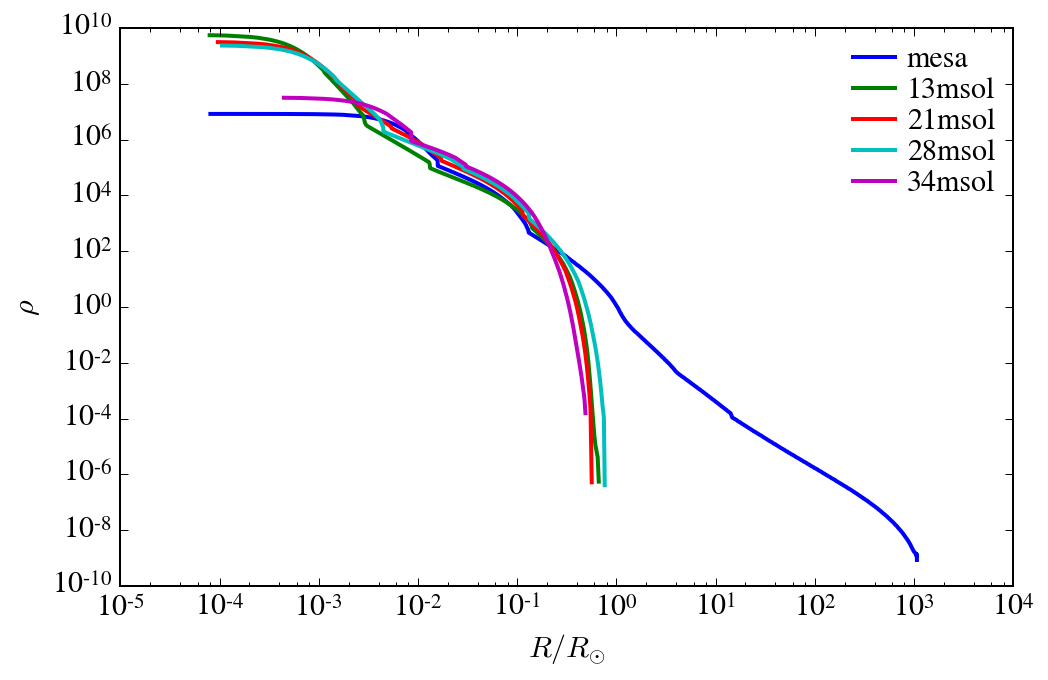

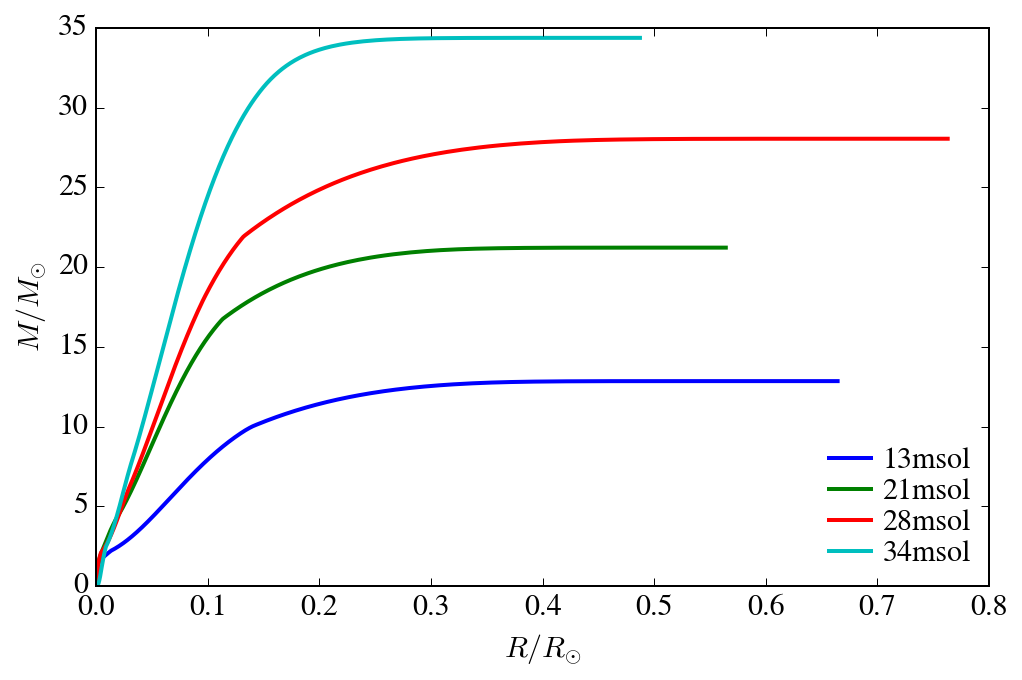

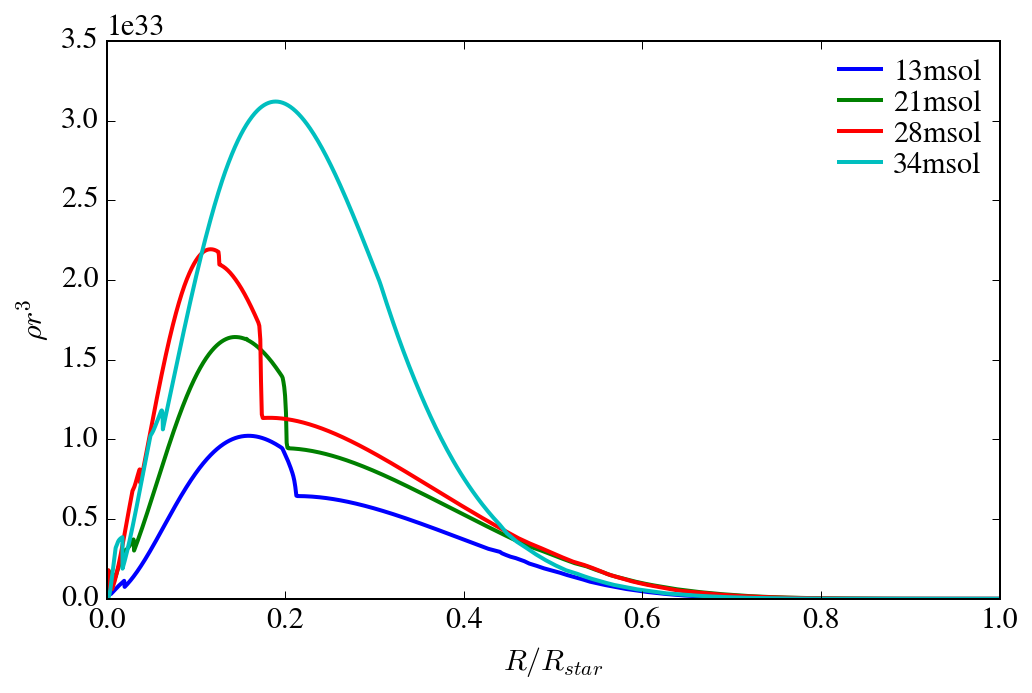

In [18]:
plt.rcParams['figure.figsize'] = (8,5)
plt.figure(1)
plt.plot(10**data['logR'],10**data['logRho'],label='mesa')
plt.plot(R_presnA/Ro,Rho_presnA,label='13msol')
plt.plot(R_presnB/Ro,Rho_presnB,label='21msol')
plt.plot(R_presnC/Ro,Rho_presnC,label='28msol')
plt.plot(R_presnD/Ro,Rho_presnD,label='34msol')
plt.legend(loc='best')
plt.loglog()
# plt.semilogy()
plt.xlabel(r'$R/R_{\odot}$')
plt.ylabel(r'$\rho$')

plt.figure(2)
# plt.plot(10**data['logR'],data['mass'],label='mesa')
plt.plot(R_presnA/Ro,M_presnA/Mo,label='13msol')
plt.plot(R_presnB/Ro,M_presnB/Mo,label='21msol')
plt.plot(R_presnC/Ro,M_presnC/Mo,label='28msol')
plt.plot(R_presnD/Ro,M_presnD/Mo,label='34msol')
# plt.semilogx()
plt.legend(loc='best')
plt.xlabel(r'$R/R_{\odot}$')
plt.ylabel(r'$M/M_{\odot}$')


plt.figure(3)
# plt.plot(10**data['logR']/Ro,10**data['logRho']*(10**data['logR'])**3,label='mesa')
plt.plot(R_presnA/R_presnA[-1],Rho_presnA*R_presnA**3,label='13msol')
plt.plot(R_presnB/R_presnB[-1],Rho_presnB*R_presnB**3,label='21msol')
plt.plot(R_presnC/R_presnC[-1],Rho_presnC*R_presnC**3,label='28msol')
plt.plot(R_presnD/R_presnD[-1],Rho_presnD*R_presnD**3,label='34msol')
plt.legend(loc='best')
# plt.loglog()
# plt.semilogy()
plt.xlabel(r'$R/R_{star}$')
plt.ylabel(r'$\rho r^3$')

## 28 $M_{\odot}$ profile

In [12]:
# Compare rotation to break up

R_star = 0.76*Ro
M_star = 28.0*Mo
print 'compactness ',M_star/R_star

wbreak = np.sqrt(G*M_star/R_star**3) 

tdyn_star = np.sqrt(R_star**3/(G*M_star))

sep = 1.52*Ro
mt = M_star + 15.0*Mo
print 'binary consist of two ',M_star/Mo,' Msol stars, seperated by ',sep/Ro, 'Rsol'

q = M_star/(mt - M_star)
f = (0.49*q**(2./3.))/(0.6*q**(2./3.) + np.log(1 + q**(1./3.)))
r1_lobe = f*5.0

print 'Fraction of rstar and roche lobe radius ',R_star/Ro/r1_lobe

P =( np.sqrt((sep)**3.0 * 4*np.pi**2/(G*(mt))))
w = 2*np.pi/P

print 'period  in dynamical timescales of the star ',P/tdyn_star

print 'fraction of break up velocity',w/wbreak

#get dt for snapshots
snapshots = 500.0  # number of snapshots per orbit
print 'snaptime ',P/TimeUnit/snapshots
print 'snaptime compared to tdyn of star ',tdyn_star/TimeUnit/0.02


compactness  1.05338777979e+24
binary consist of two  28.0  Msol stars, seperated by  1.52 Rsol
Fraction of rstar and roche lobe radius  0.350340664273
period  in dynamical timescales of the star  14.3406768542
fraction of break up velocity 0.438137290942
snaptime  0.00359121178966
snaptime compared to tdyn of star  6.26053397996


## 13 $M_{\odot}$ profile

In [20]:
# Compare rotation to break up

R_star = 0.5*Ro
M_star = 13.0*Mo
print 'compactness ',M_star/R_star

wbreak = np.sqrt(G*M_star/R_star**3) 

tdyn_star = np.sqrt(R_star**3/(G*M_star))

sep = 10.0*R_star
mt = 2*M_star

print 'binary consist of two ',M_star/Mo,' Msol stars, seperated by ',sep/Ro, 'Rsol'

q = M_star/(mt - M_star)
f = (0.49*q**(2./3.))/(0.6*q**(2./3.) + np.log(1 + q**(1./3.)))
r1_lobe = f*5.0

print 'Fraction of rstar and roche lobe radius ',R_star/Ro/r1_lobe

P =( np.sqrt((sep)**3.0 * 4*np.pi**2/(G*(mt))))
w = 2*np.pi/P

print 'period  in dynamical timescales of the star ',P/tdyn_star

print 'fraction of break up velocity',w/wbreak


#get dt for snapshots
snapshots = 500.0  # number of snapshots per orbit
print 'snaptime ',P/TimeUnit/snapshots
print 'snaptime compared to tdyn of star ',tdyn_star/TimeUnit/0.01




compactness  7.43390804598e+23
binary consist of two  13.0  Msol stars, seperated by  5.0 Rsol
Fraction of rstar and roche lobe radius  0.263907587869
period  in dynamical timescales of the star  140.496294621
fraction of break up velocity 0.04472135955
snaptime  0.0275535903023
snaptime compared to tdyn of star  9.80580675691


## 34 $M_{\odot}$ profile

In [21]:
# Compare rotation to break up

R_star = 0.4*Ro
M_star = 34.0*Mo
print 'compactness ',M_star/R_star

wbreak = np.sqrt(G*M_star/R_star**3) 

tdyn_star = np.sqrt(R_star**3/(G*M_star))

sep = 10.0*R_star
mt = 2*M_star

print 'binary consist of two ',M_star/Mo,' Msol stars, seperated by ',sep/Ro, 'Rsol'

q = M_star/(mt - M_star)
f = (0.49*q**(2./3.))/(0.6*q**(2./3.) + np.log(1 + q**(1./3.)))
r1_lobe = f*5.0

print 'Fraction of rstar and roche lobe radius ',R_star/Ro/r1_lobe

P =( np.sqrt((sep)**3.0 * 4*np.pi**2/(G*(mt))))
w = 2*np.pi/P

print 'period  in dynamical timescales of the star ',P/tdyn_star

print 'fraction of break up velocity',w/wbreak


#get dt for snapshots
snapshots = 500.0  # number of snapshots per orbit
print 'snaptime ',P/TimeUnit/snapshots
print 'snaptime compared to tdyn of star ',tdyn_star/TimeUnit/0.005




compactness  2.43031609195e+24
binary consist of two  34.0  Msol stars, seperated by  4.0 Rsol
Fraction of rstar and roche lobe radius  0.211126070296
period  in dynamical timescales of the star  140.496294621
fraction of break up velocity 0.04472135955
snaptime  0.0121911702056
snaptime compared to tdyn of star  8.67721831275


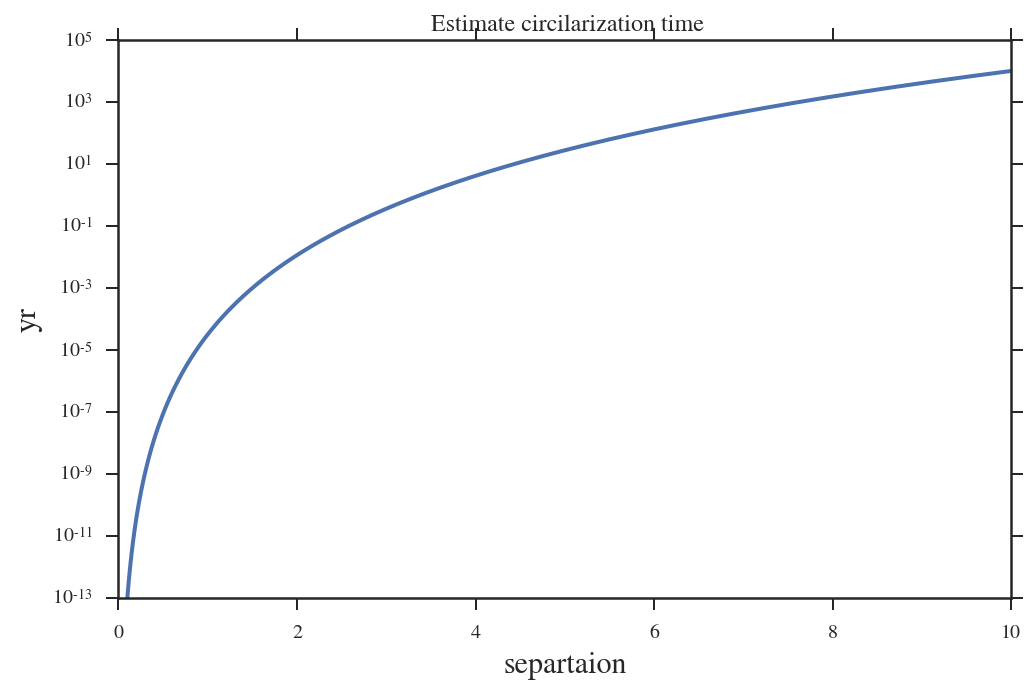

In [32]:
Rlist = np.logspace(-1,1,100)
tmerge = 5./512. * c**5/(G**3*(30*Mo)**3)*(Rlist*Ro)**4
t_tau = 2.1*10**7*(tmerge/(60*60*24*365.25*1e9))**(17./8.)
plt.plot(Rlist,t_tau)
plt.semilogy()
plt.ylabel('yr')
plt.xlabel('separtaion')
plt.title(' Estimate circilarization time')
# plt.savefig('/Users/sophielundschroder/Dropbox/Sophie_projectSpin/Paper/figures/Cicularization.pdf')

